In [787]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.path.join(os.path.pardir, 'code'))

import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import pynumdiff
import figurefirst as fifi
import figure_functions as ff
import pickle
import pandas as pd

from simulator import FlyWindDynamics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize simulator

In [788]:
# # SI units
# m = 0.25e-6 # [kg]
# I = 4.971e-12  # [N*m*s^2] yaw mass moment of inertia: 10.1242/jeb.038778
# C_phi = 27.36e-12  # [N*m*s] yaw damping: 10.1242/jeb.038778
# C_para = m / 0.170  # [N*s/m] calculate using the mass and time constant reported in 10.1242/jeb.098665
# C_perp = C_para  # assume same as C_para

In [789]:
# # Convert to units of mg & mm to help with scaling for ODE solver
# m = m * 1e6  # [mg]
# I = I * 1e6 * (1e3)**2  # [mg*mm/s^2 * mm*s^2]
# C_phi = C_phi * 1e6 * (1e3)**2  # [mg*mm/s^2 *m*s]
# C_para = C_para * 1e6  # [mg/s]
# C_perp = C_perp * 1e6  # [mg/s]

In [790]:
# For simulation
m = 0.01
I = 0.05
C_phi = 1.0
C_para = 1.0
C_perp = 1.0

In [791]:
print('m:', m, '\nI:', I, '\nC_phi:', C_phi, '\nC_para:', C_para, '\nC_perp:', C_perp)

m: 0.01 
I: 0.05 
C_phi: 1.0 
C_para: 1.0 
C_perp: 1.0


In [792]:
simulator = FlyWindDynamics(polar_mode=False, control_mode='open_loop',
                            m=m, I=I, C_phi=C_phi, C_para=C_para, C_perp=C_perp)

### Set simulation time

In [793]:
# Simulation time
fs = 50.0  # sampling frequency [hz]
T = 0.2  # simulation time [s]
dt = 1 / fs  # sampling time [s]
tsim = np.arange(0, T + dt, dt).T  # simulation time vector [s]

In [794]:
tsim.shape

(11,)

### Set control commands

In [795]:
# Wind
w = 0.2 * np.ones_like(tsim)
zeta = 0.0 * np.ones_like(tsim)

wdot = pynumdiff.finite_difference.second_order(w, dt)[1]
zetadot = pynumdiff.finite_difference.second_order(zeta, dt)[1]

# Thrust
r_para = 1.0 * np.ones_like(tsim)
r_perp = 0.0 * np.ones_like(tsim)

# Heading
r_phi = 0.0 * np.ones_like(tsim)
r_phi[2:5] = 30.0 # add turn (this is where we would input delta WBA)

In [796]:
# Collect commands
usim = np.stack((r_para, r_perp, r_phi, wdot, zetadot), axis=1)

### Set initial conditions

In [797]:
v_para_0 = r_para[0]  # parallel ground speed
v_perp_0 = r_perp[0]  # perpendicular ground speed
phi0 = np.pi / 2  # heading in global frame
phidot0 = 0.0  # angular velocity
w0 = w[0]  # wind speed
zeta0 = zeta[0] # wind direction in global frame

In [798]:
# Collect initial conditions
x0 = np.array([v_para_0, v_perp_0, phi0, phidot0, w0, zeta0])

### Run simulation

In [799]:
sim_data = simulator.simulate(x0, tsim, usim)
sim_data.keys()

dict_keys(['time', 'x', 'v_para', 'v_perp', 'phi', 'phidot', 'w', 'zeta', 'xvel', 'yvel', 'xpos', 'ypos', 'g', 'psi', 'a', 'gamma', 'a_para', 'a_perp', 'q', 'alpha', 'beta', 'dir_of_travel', 'r_para', 'r_perp', 'r_phi', 'u_para', 'u_perp', 'u_phi', 'u_g', 'u_psi', 'v_para_dot', 'v_perp_dot', 'phiddot', 'wdot', 'zetadot'])

In [800]:
pd.DataFrame(sim_data['x'], columns=simulator.state_names)

,v_para,v_perp,phi,phidot,w,zeta
0,1.0,0.0,1.570796,0.0,0.2,0.0
1,1.0,0.0,1.570796,0.0,0.2,0.0
2,1.0,0.0,1.570796,0.0,0.2,0.0
3,1.0,0.0,1.570796,0.0,0.2,0.0
4,1.0,0.0,1.570796,0.0,0.2,0.0
5,1.0,0.0,1.570796,0.0,0.2,0.0
6,1.0,0.0,1.570796,0.0,0.2,0.0
7,1.0,0.0,1.570796,0.0,0.2,0.0
8,1.0,0.0,1.570796,0.0,0.2,0.0
9,1.0,0.0,1.570796,0.0,0.2,0.0


In [801]:
crange = 0.1
cmap = cm.get_cmap('Blues')
cmap = cmap(np.linspace(crange, 1, 100))
cmap = ListedColormap(cmap)

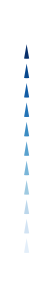

In [802]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ff.plot_trajectory(sim_data['xpos'],
                   sim_data['ypos'],
                   sim_data['phi'],
                   color=sim_data['time'],
                   ax=ax,
                   size_radius=0.015,
                   nskip=0,
                   colormap=cmap)

fifi.mpl_functions.adjust_spines(ax, [])

### Plot heading angle & air speed angle over time

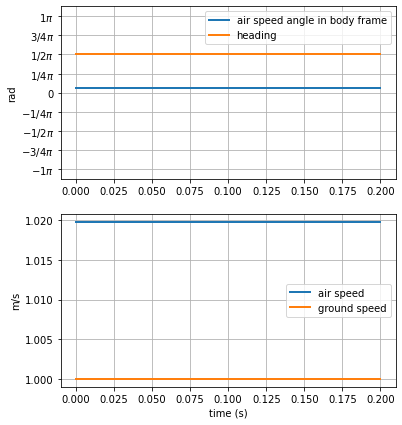

In [803]:
fig, ax = plt.subplots(2, 1, figsize=(6, 7))

ax[0].plot(sim_data['time'], sim_data['gamma'], lw=2, label='air speed angle in body frame')
ax[0].plot(sim_data['time'], sim_data['phi'], lw=2, label='heading')

ff.pi_yaxis(ax[0], tickpispace=0.25)

ax[0].grid()
ax[0].set_ylabel('rad')
ax[0].legend()

ax[1].plot(sim_data['time'], sim_data['a'], lw=2, label='air speed')
ax[1].plot(sim_data['time'], sim_data['g'], lw=2, label='ground speed')

ax[1].grid()
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('m/s')
ax[1].legend()

In [767]:
sim_data['g']

array([1.        , 1.01484275, 1.00945118, 0.96660015, 0.89573108,
       0.83236688, 0.80605033, 0.79855489, 0.7978913 , 0.79930282,
       0.8010514 ])

### Save data

In [768]:
savepath = os.path.join(os.path.pardir, 'simulation_data', 'offline_trajectory_example.pk')

In [769]:
with open(savepath, 'wb') as fp:
    pickle.dump(sim_data, fp)

### Load data

In [770]:
with open(savepath, 'rb') as fp:
    data = pickle.load(fp)